In [219]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Final Project - Exploring Steam Game Trends and Predicting Game Popularity and Prices

## 1. Data Cleaning and Integration

1.1 Cleaning the data in applicationInformation.csv. This file contains the game names, a free to play boolean attribute, and the appid of a game. The appids are an important part in figuring the prices of a game, the player counts of a game, and will help use integrate other file's data into this dataframe.

In [220]:
import pandas as pd
import os.path
import numpy as np

# df will be our main dataframe that we intergate all the other dataframes into
# Starting file: applicationInformation.csv
df = pd.read_csv("steam_dataset/applicationInformation.csv", encoding= 'unicode_escape')

# Not all applications in this dataset are games. There are demos, ads, dlcs, etc.
# We can't assume that missing values for types are games, so remove these data instances.
df.dropna(subset=['type'], inplace=True)
for i in df["type"]:
    if(i != 'game'):
        df = df[df.type != i]

# Every Game has to be identifiable by some number otherwise integration with other files in datset is impossible.
df.dropna(subset=['appid'], inplace=True)

# Every game needs a name.
df.dropna(subset=['name'], inplace=True)

# We are not using the releasedate attribute for anything, so delete it.
df.drop(columns=['releasedate'], inplace=True)

# If freetoplay value is missing then we can assume that it is not free to play. Set missing value to 0 (aka not free to play)
df['freetoplay'].fillna(0, inplace=True)

df

,appid,type,name,freetoplay
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,0.0
1,570,game,Dota 2,1.0
2,730,game,Counter-Strike: Global Offensive,1.0
4,359550,game,Tom Clancy's Rainbow Six Siege,0.0
5,271590,game,Grand Theft Auto V,0.0
...,...,...,...,...
1993,64000,game,Men of War: Assault Squad,0.0
1994,227860,game,Castle Story,0.0
1997,429050,game,Feed and Grow: Fish,0.0
1998,209650,game,Call of Duty: Advanced Warfare,0.0


1.2 Integrate applicationGenres.csv data into dataframe df. This file contains the appid along with the genres the given appid is categorized as.

In [221]:
# Max of 8 genres
genre_df = pd.read_csv("steam_dataset/applicationGenres.csv", names=['appid', 'Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6', 'Genre 7', 'Genre 8'])

# A set that will keep track of all the possible genres
genre_names = set()

# Make all missing values 0s
# Missing value means that the game is uncategorizable or has less than 8 genres
genre_df = genre_df.fillna(0)

# Find all possible genres for a game
# If genre is free to play or 0 (aka Missing) ignore it.
# Don't store it in genre_names because freetoplay exists in df and 0 is not a name.
for i in range(1, 9):
  for genre in genre_df[f'Genre {i}']:
    if genre not in genre_names and genre != 'Free to Play' and genre != 0:
      genre_names.add(genre)

# Add these Genre names as columns to the dataframe with intial values of 0 for all rows
# Each new attribute we added is a boolean attribute.
for name in genre_names:
  df[f'{name.replace(" ","")}'] = 0

# Go through each game id in original/main dataframe, df. 
# Find and set their genres.
for id in df['appid']:
  for i in range(1, 9):
    genre = genre_df[genre_df.appid == id][f'Genre {i}']
    for g in genre:
      genre = g
    if genre != 0 and genre != 'Free to Play':
      df.loc[df.appid == id, genre.replace(" ","")] = 1

df

,appid,type,name,freetoplay,EarlyAccess,AudioProduction,Strategy,MassivelyMultiplayer,Action,Utilities,...,SoftwareTraining,Adventure,Education,Sports,Simulation,Animation&Modeling,PhotoEditing,VideoProduction,60,Violent
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,0.0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,570,game,Dota 2,1.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,730,game,Counter-Strike: Global Offensive,1.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,359550,game,Tom Clancy's Rainbow Six Siege,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,271590,game,Grand Theft Auto V,0.0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,64000,game,Men of War: Assault Squad,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1994,227860,game,Castle Story,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,429050,game,Feed and Grow: Fish,0.0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1998,209650,game,Call of Duty: Advanced Warfare,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


1.3 Clean df dataframe. Remove genres that don't make sense and applications that fall in those genres. These are not actual games even if their type is 'game'. If you look them up they are not games, so remove them.

In [222]:
# Remove Games that are classified by genres that don't make sense.
for id in df[df.AudioProduction == 1]['appid']:
  df = df[df.appid != id]

for id in df[df.Utilities == 1]['appid']:
  df = df[df.appid != id]

for id in df[df.WebPublishing == 1]['appid']:
  df = df[df.appid != id]

for id in df[df['Design&Illustration'] == 1]['appid']:
  df = df[df.appid != id]

for id in df[df.SoftwareTraining == 1]['appid']:
  df = df[df.appid != id]

for id in df[df['Animation&Modeling'] == 1]['appid']:
  df = df[df.appid != id]

for id in df[df.PhotoEditing == 1]['appid']:
  df = df[df.appid != id]

for id in df[df.VideoProduction == 1]['appid']:
  df = df[df.appid != id]

for id in df[df['60'] == 1]['appid']:
  df = df[df.appid != id]

# Finally drop these Columns.
df.drop(columns=['AudioProduction', 'Utilities', 'WebPublishing', 'Design&Illustration', 'SoftwareTraining', 'Animation&Modeling', 'PhotoEditing', 'VideoProduction', '60', 'SexualContent'], inplace=True)

df

,appid,type,name,freetoplay,EarlyAccess,Strategy,MassivelyMultiplayer,Action,Casual,Gore,Racing,RPG,Nudity,Indie,Adventure,Education,Sports,Simulation,Violent
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,0.0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
1,570,game,Dota 2,1.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,730,game,Counter-Strike: Global Offensive,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,359550,game,Tom Clancy's Rainbow Six Siege,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,271590,game,Grand Theft Auto V,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,64000,game,Men of War: Assault Squad,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1994,227860,game,Castle Story,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1997,429050,game,Feed and Grow: Fish,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0
1998,209650,game,Call of Duty: Advanced Warfare,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


1.4 Integrating the data from PriceHistory into our data frame (df). We found the average price of a game and added it to the data frame (df).

In [223]:
averagePrices = []

# Finalprice is the price after the discount is applied to the Initialprice, so use this to calculate averageprice of a game.
for id in df['appid']:
  filename = str(id) + '.csv'
  if os.path.exists(f'steam_dataset/PriceHistory/{filename}'):
    game_price_df = pd.read_csv(f'steam_dataset/PriceHistory/{filename}', encoding= 'unicode_escape')
    totalprice = 0.0
    count = 0
    for price in game_price_df['Finalprice']:
      totalprice+=price
      count+=1
    averagePrices.append(round((totalprice/count), 2))
  else:
    averagePrices.append(0.0)

df['averageprice'] = averagePrices

df

,appid,type,name,freetoplay,EarlyAccess,Strategy,MassivelyMultiplayer,Action,Casual,Gore,Racing,RPG,Nudity,Indie,Adventure,Education,Sports,Simulation,Violent,averageprice
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,0.0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,27.56
1,570,game,Dota 2,1.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00
2,730,game,Counter-Strike: Global Offensive,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00
4,359550,game,Tom Clancy's Rainbow Six Siege,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,17.08
5,271590,game,Grand Theft Auto V,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,25.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,64000,game,Men of War: Assault Squad,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8.82
1994,227860,game,Castle Story,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,22.63
1997,429050,game,Feed and Grow: Fish,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,14.88
1998,209650,game,Call of Duty: Advanced Warfare,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,53.64


1.5 Integrating the data from PlayerCountHistory1 and PlayerCountHistory2 to our data frame (df).

In [224]:
averageplayercount = []

for id in df['appid']:
  filename = str(id) + '.csv'
  game_playercount_df = ''
  if os.path.exists(f'steam_dataset/PlayerCountHistoryPart1/{filename}'):
    game_playercount_df = pd.read_csv(f'steam_dataset/PlayerCountHistoryPart1/{filename}')
  elif os.path.exists(f'steam_dataset/PlayerCountHistoryPart2/{filename}'):
    game_playercount_df = pd.read_csv(f'steam_dataset/PlayerCountHistoryPart2/{filename}')
  else:
    averageplayercount.append(0)
    continue
  totalplayers = 0
  count = 0
  game_playercount_df['Playercount'] = game_playercount_df['Playercount'].fillna(0)
  for playercount in game_playercount_df['Playercount']:
    totalplayers+=playercount
    count+=1
  averageplayercount.append(round((totalplayers/count), 2))

df['averageplayercount'] = averageplayercount

df

,appid,type,name,freetoplay,EarlyAccess,Strategy,MassivelyMultiplayer,Action,Casual,Gore,...,RPG,Nudity,Indie,Adventure,Education,Sports,Simulation,Violent,averageprice,averageplayercount
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,0.0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,27.56,534928.79
1,570,game,Dota 2,1.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0.00,459574.81
2,730,game,Counter-Strike: Global Offensive,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.00,427094.35
4,359550,game,Tom Clancy's Rainbow Six Siege,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,17.08,74232.19
5,271590,game,Grand Theft Auto V,0.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,25.88,74215.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,64000,game,Men of War: Assault Squad,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,8.82,86.63
1994,227860,game,Castle Story,0.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,22.63,80.30
1997,429050,game,Feed and Grow: Fish,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,14.88,276.20
1998,209650,game,Call of Duty: Advanced Warfare,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,53.64,76.69


1.5 Add a count column

In [225]:
df['count'] = 1
df.head(30)

,appid,type,name,freetoplay,EarlyAccess,Strategy,MassivelyMultiplayer,Action,Casual,Gore,...,Nudity,Indie,Adventure,Education,Sports,Simulation,Violent,averageprice,averageplayercount,count
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,0.0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,27.56,534928.79,1
1,570,game,Dota 2,1.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0.00,459574.81,1
2,730,game,Counter-Strike: Global Offensive,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.00,427094.35,1
4,359550,game,Tom Clancy's Rainbow Six Siege,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,17.08,74232.19,1
5,271590,game,Grand Theft Auto V,0.0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,25.88,74215.78,1
6,238960,game,Path of Exile,1.0,0,0,1,1,0,0,...,0,1,1,0,0,0,0,0.00,26815.41,1
7,230410,game,Warframe,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.00,50398.59,1
8,440,game,Team Fortress 2,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.00,50453.49,1
9,252950,game,Rocket League,0.0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,18.14,35646.51,1
10,252490,game,Rust,0.0,0,0,1,1,0,0,...,0,1,1,0,0,0,0,34.55,42847.18,1


# 2. Data Summary

In [226]:
df.describe()

,appid,freetoplay,EarlyAccess,Strategy,MassivelyMultiplayer,Action,Casual,Gore,Racing,RPG,Nudity,Indie,Adventure,Education,Sports,Simulation,Violent,averageprice,averageplayercount,count
count,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.0,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.0
mean,336631.279517,0.182867,0.046129,0.289951,0.103240,0.481604,0.165843,0.003844,0.034047,0.253158,0.002746,0.449753,0.303679,0.0,0.046678,0.239978,0.007688,13.332241,1621.450253,1.0
std,185904.860685,0.386663,0.209821,0.453864,0.304356,0.499799,0.372042,0.061898,0.181400,0.434940,0.052342,0.497605,0.459972,0.0,0.211005,0.427187,0.087368,12.717892,19708.507613,0.0
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.010000,1.0
25%,228760.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.690000,31.930000,1.0
50%,337950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,11.840000,80.250000,1.0
75%,467120.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,18.560000,259.520000,1.0
max,748370.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,77.390000,534928.790000,1.0


# 3. Data Visualization

In [227]:
import matplotlib.pyplot as plt

3.1 Compare the number of free games to the number of paid games. Which category is larger?

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:xlabel='freetoplay'>

Text(0, 0.5, 'Number of Games')

Text(0.5, 0, 'Category')

([<matplotlib.axis.XTick at 0x7fcb35d1de50>,
 [Text(0, 0, 'Paid'), Text(1, 0, 'Free')])

Text(0.5, 1.0, 'Number of free steam games compared to the number of paid steam games')

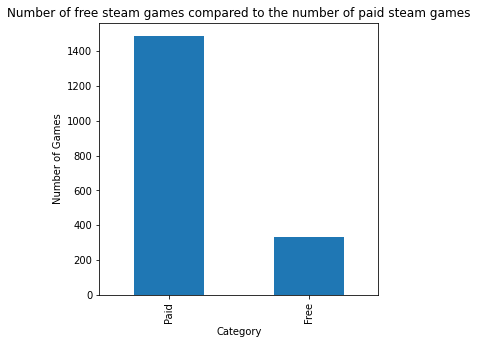

In [228]:
# Group by freetoplay and only look at the count column
free_and_paid = df.groupby('freetoplay').sum()
free_and_paid = free_and_paid['count']

# Plot
plt.subplots(figsize=(5, 5))

free_and_paid.plot.bar()

plt.ylabel('Number of Games')
plt.xlabel('Category')
x = ['Paid', 'Free']
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.title('Number of free steam games compared to the number of paid steam games')
plt.show()

Findings:
- There are a lot more paid steam games than there are free steam games. One possiblility for this could be due to the fact that developers want to profit off of their hard work instead of letting people use games for free.

3.2 Compare the number of free games to the number of paid games. Which category has more players?

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:xlabel='freetoplay'>

Text(0, 0.5, 'Number of Players')

Text(0.5, 0, 'Category')

([<matplotlib.axis.XTick at 0x7fcb3862feb0>,
 [Text(0, 0, 'Paid'), Text(1, 0, 'Free')])

Text(0.5, 1.0, 'Number of players that play free games compared to paid games')

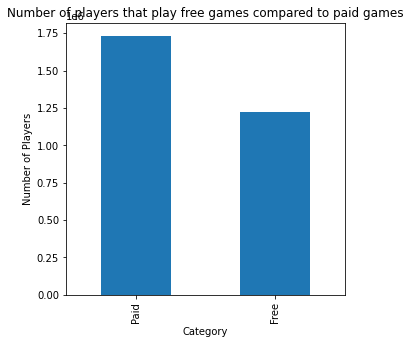

In [229]:
# Group by freetoplay and only look at the averageplayercount column
free_and_paid = df.groupby('freetoplay').sum()
free_and_paid = free_and_paid['averageplayercount']

# Plot
plt.subplots(figsize=(5, 5))

free_and_paid.plot.bar()

plt.ylabel('Number of Players')
plt.xlabel('Category')
x = ['Paid', 'Free']
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.title('Number of players that play free games compared to paid games')
plt.show()

Finidngs: 
- A lot more players use and play paid games than compared to free games. This makes sense because there are a lot more paid games than free games on the steam store. 
- Compared to the significant difference between the number of paid games and the number of free games, there is less of a gap/difference in the number of people who play paid games and the number of people who play free games.

3.3 Compare price of game to number of players.

(<Figure size 1440x1080 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:xlabel='averageprice'>

Text(0, 0.5, 'Number of Players')

Text(0.5, 0, 'Price of Game')

Text(0.5, 1.0, 'The relationship between price of game and number of players')

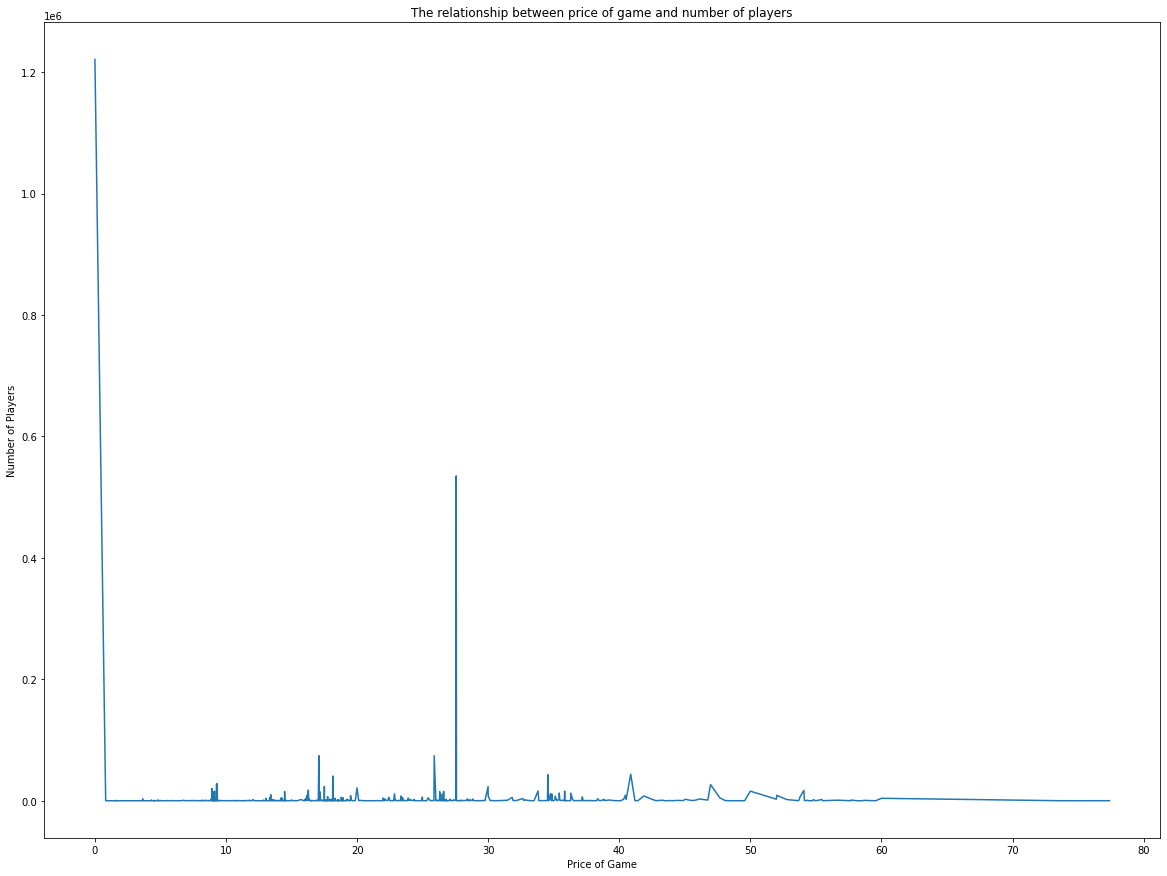

In [230]:
df.sort_values(by='averageprice', ascending=True, inplace=True)

# Group by averageprice and only look at the averageplayercount column
price_and_playercount = df.groupby('averageprice').sum()
price_and_playercount = price_and_playercount['averageplayercount']

# Plot
plt.subplots(figsize=(20, 15))

price_and_playercount.plot()

plt.ylabel('Number of Players')
plt.xlabel('Price of Game')
plt.title('The relationship between price of game and number of players')
plt.show()


Findings:
- The most played games are the games that cost $0.00 (Free).
- The least played games are those that are greater than $60.
- If we exclude free games from this graph the most played games fall in the range of $20-$40. The Most played games cost around $25.

3.4 What are the 5 most played games on steam?

(<Figure size 720x360 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:ylabel='name'>

Text(0, 0.5, 'Game Title')

Text(0.5, 0, 'Number of players on average')

Text(0.5, 1.0, 'Top 5 Steam Games')

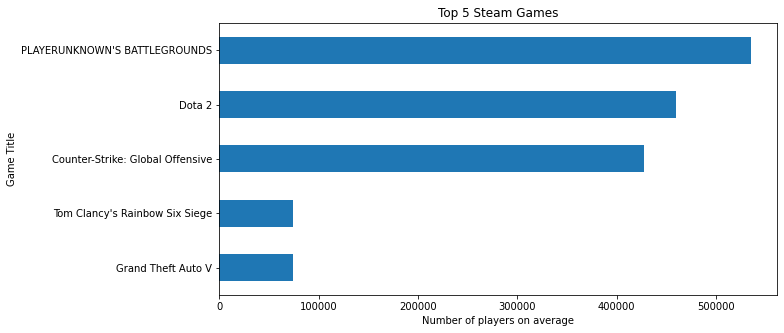

In [231]:
df.sort_values(by='averageplayercount', ascending=False, inplace=True)

top_five_games = df.head(5)
top_five_games = top_five_games.groupby('name').sum()
top_five_games.sort_values(by='averageplayercount', ascending=True, inplace=True)
top_five_games = top_five_games['averageplayercount']

# Plot
plt.subplots(figsize=(10, 5))

top_five_games.plot.barh()

plt.ylabel('Game Title')
plt.xlabel('Number of players on average')
plt.title('Top 5 Steam Games')
plt.show()

3.5 What are the 5 least played games on steam?

(<Figure size 720x360 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:ylabel='name'>

Text(0, 0.5, 'Game Title')

Text(0.5, 0, 'Number of players on average')

Text(0.5, 1.0, '5 Least Played Steam Games')

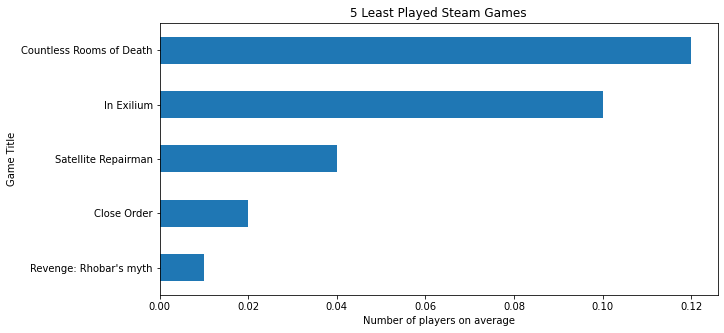

In [232]:
df.sort_values(by='averageplayercount', ascending=True, inplace=True)

lowest_five_games = df.head(5)
lowest_five_games = lowest_five_games.groupby('name').sum()
lowest_five_games.sort_values(by='averageplayercount', ascending=True, inplace=True)
lowest_five_games = lowest_five_games['averageplayercount']

# Plot
plt.subplots(figsize=(10, 5))

lowest_five_games.plot.barh()

plt.ylabel('Game Title')
plt.xlabel('Number of players on average')
plt.title('5 Least Played Steam Games')
plt.show()

# 4. Modeling and Analysis

## Part 1 - Predicting Popularity Based on Price (Using Linear Regression)

In [257]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Convert df columns of interest to numpy arrays
averagePrice = np.asarray(df['averageprice'])
averagePrice = averagePrice[:, np.newaxis]
popularity = np.asarray(df['averageplayercount'])
popularity = popularity[:, np.newaxis]

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(averagePrice, popularity, test_size = 0.20)

# Create linear regression object
m1 = LinearRegression()

# Train the model with training data 
m1.fit(X_train, y_train)

# Make predictions on test data 
popularity_predictions = m1.predict(X_test)

#print the coefficient 
print('Coefficients:', m1.coef_)

#print the mean squared error
print('mean squared error: %.2f'% mean_squared_error(y_test, popularity_predictions))

# print the r-squared
print('R-squared: %.2f' % r2_score(y_test, popularity_predictions))

LinearRegression()

Coefficients: [[9.82253152]]
mean squared error: 21509992.32
R-squared: -0.02


Text(0.5, 1.0, 'Linear Regression for predicting popularity based on price')

Text(0.5, 0, 'Average Price of Game')

Text(0, 0.5, 'Popularity (Player Count)')

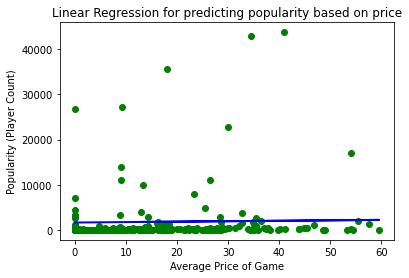

In [264]:
# Plot 
plt.scatter(X_test, y_test,  color='green')
plt.plot(X_test, popularity_predictions, color='blue', linewidth=2)
plt.title('Linear Regression for predicting popularity based on price')
plt.xlabel('Average Price of Game')
plt.ylabel('Popularity (Player Count)')
plt.show()

## Part 2 - Predicting Free To Play (Using KNN)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()


In [23]:
df2 = df.copy()
df2.drop('appid',axis=1,inplace=True)
df2.drop('name',axis=1,inplace=True)
df2.drop('averageprice',axis=1,inplace=True)
df2.drop('type',axis=1,inplace=True)
df2.drop('count',axis=1,inplace=True)
df2.drop('freetoplay',axis=1,inplace=True)


In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df2.iloc[:,:],df['freetoplay'])

In [25]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [26]:
y_pred = knn.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error,accuracy_score
mean_squared_error(y_test,y_pred)
accuracy_score(y_test,y_pred)

0.19298245614035087

0.8070175438596491

In [28]:
from sklearn import svm
clf1 = svm.SVC(kernel='rbf')

# Fit data
clf1.fit(X_train, y_train)

# Predict
y_predict = clf1.predict(X_test)

SVC()

In [29]:
from sklearn.metrics import mean_squared_error,accuracy_score
mean_squared_error(y_test,y_pred)
accuracy_score(y_test,y_pred)

0.19298245614035087

0.8070175438596491

In [30]:
from sklearn.decomposition import PCA
PCA = PCA (n_components = 2) 
X_train = PCA.fit_transform(X_train)
X_test = PCA.fit_transform(X_test)

In [31]:
def meshGrid (x , y , h):
    '''x is data for x-axis meshgrid
       y is data for y-axis meshgrid
       h is stepsize
    '''
    x_min, x_max = x.min() - 1 , x.max() + 1
    y_min, y_max = y.min() - 1 , y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    return xx , yy

In [32]:

from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn import metrics
#Import SVM



cmap_light = ListedColormap(['#FBBBB9', '#82CAFF']) 
cmap_bold = ListedColormap(['#CA226B', '#2B65EC']) 
cmap_test = ListedColormap(['#8E35EF', '#659EC7'])
cmap_predict = ListedColormap(['#FCDFFF', '#E0FFFF'])

# clf1 is a linear svm classifier
clf1 = knn

# Fit data
clf1.fit(X_train, y_train)

# Predict
ys_predict = clf1.predict(X_test)


#Display the outcome of classification
print(metrics.classification_report(y_test, ys_predict))
print(metrics.confusion_matrix(y_test, ys_predict))

# Display the svm 
xx , yy = meshGrid(X_train[:,0], X_train[:,1], 0.01)



Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap=cmap_light ,levels=[-1, 0, 1] ,alpha = 0.5)

# For plotting all data use the following line
#plt.scatter(Xs[:, 0], Xs[:, 1], c=ys, cmap=cmap_bold, edgecolor='k', s=50)

# For plotting train and test and prediction separatley 
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,edgecolor='k', s=40)
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=1.0,c = y_test, cmap=cmap_test,linewidth=1, marker='o', s=90)
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=1.0,c = ys_predict, cmap=cmap_predict ,linewidth=1, marker='X', s=40)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()
    

KNeighborsClassifier()

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       371
         1.0       0.13      0.07      0.09        85

    accuracy                           0.74       456
   macro avg       0.47      0.48      0.47       456
weighted avg       0.68      0.74      0.71       456

[[330  41]
 [ 79   6]]


In [ ]:

from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn import metrics
#Import SVM



cmap_light = ListedColormap(['#FBBBB9', '#82CAFF']) 
cmap_bold = ListedColormap(['#CA226B', '#2B65EC']) 
cmap_test = ListedColormap(['#8E35EF', '#659EC7'])
cmap_predict = ListedColormap(['#FCDFFF', '#E0FFFF'])

# clf1 is a linear svm classifier
clf1 = svm.SVC(kernal = 'rbf')

# Fit data
clf1.fit(X_train, y_train)

# Predict
ys_predict = clf1.predict(X_test)


#Display the outcome of classification
print(metrics.classification_report(y_test, ys_predict))
print(metrics.confusion_matrix(y_test, ys_predict))

# Display the svm 
xx , yy = meshGrid(X_train[:,0], X_train[:,1], 0.01)



Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap=cmap_light ,levels=[-1, 0, 1] ,alpha = 0.5)

# For plotting all data use the following line
#plt.scatter(Xs[:, 0], Xs[:, 1], c=ys, cmap=cmap_bold, edgecolor='k', s=50)

# For plotting train and test and prediction separatley 
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,edgecolor='k', s=40)
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=1.0,c = y_test, cmap=cmap_test,linewidth=1, marker='o', s=90)
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=1.0,c = ys_predict, cmap=cmap_predict ,linewidth=1, marker='X', s=40)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()
    